In [1]:
%load_ext autoreload
%autoreload

In [2]:
import math
import random
import importlib
import gato.policy.mini_gato as mg
from datasets import load_dataset
import requests
import torch
import torch.nn.functional as F
from torchvision.transforms import ToTensor, Resize, RandomCrop
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
import os
os.environ["NCCL_P2P_DISABLE"] = "1"
os.environ["NCCL_IB_DISABLE"] = "1"

# Working demo

First, a quick demo that this works. The datasets and model parameters are hardcoded in `mini_gato.py` for now.

In [4]:
model = mg.init_model()

In [5]:
model, lm_head, optimizer, accelerator, text_dataloader, vqa_dataloader = mg.train(model)

/home/eihli/.virtualenvs/neko/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


Epoch [0/50], Loss: 10.991362571716309
Epoch [10/50], Loss: 6.075538158416748
Epoch [20/50], Loss: 6.930920124053955
Epoch [30/50], Loss: 6.957139492034912
Epoch [40/50], Loss: 4.904222011566162


# § 2.1 Tokenization

## Text tokenization

> There are infinite possible ways to transform data into tokens, including directly using the raw underlying byte stream. Below we report the tokenization scheme we found to produce the best results for Gato at the current scale using contemporary hardware and model architectures.
> Text is encoded via SentencePiece (Kudo & Richardson, 2018) with 32000 subwords into the integer range [0, 32000).
> ...

For this example, we'll use GPT2. The only thing to note as you change tokenizers is that discrete/continuous values get tokenized to the 1024 numbers after the vocab size (32000 to 33024 in the case of SentencePiece). So, you'll need to make that update as you change tokenizers.

GPT2 has a vocab size of 50256, so our discrete/continuous values will tokenize to the range 50256 to 51280.

### Example text dataset/dataloader

Here's a couple of example text datasets/dataloaders.

#### Dataset

How you get the dataset doesn't much matter. All that matters is:

- It's an iterator (we expect to be using datasets too large to fit in memory).
- It has train/valid/test splits.

In [6]:
wikitext_dataset = load_dataset(path="wikitext", name="wikitext-2-v1", streaming=True)

In [7]:
wikitext_dataset

IterableDatasetDict({
    test: IterableDataset({
        features: ['text'],
        n_shards: 1
    })
    train: IterableDataset({
        features: ['text'],
        n_shards: 1
    })
    validation: IterableDataset({
        features: ['text'],
        n_shards: 1
    })
})

#### Cleaning and transforming the dataset

The Wikitext dataset contains a lot of samples that are empty.

We can remove those with a call to `.filter(lambda: x: x["text"] != '')`.

In [8]:
next(iter(wikitext_dataset["train"]))

{'text': ''}

In [9]:
next(
    iter(
        wikitext_dataset["train"]
          .filter(lambda x: x["text"] != '')
    )
)

{'text': ' = Valkyria Chronicles III = \n'}

Remember, though, each dataset is unique. 

This filter is necessary and works for wikitext, but it might not be the right filter to use for some other dataset. That's why it's important to have flexible api's, like `filter` and `map`, and a solid set of _composable_ utility functions, like `is_empty` and `not`.

It's debatable whether we should tokenize here, at the stage where we're working with the Dataset, or somewhere else. The dimensions you might need to consider are performance, complexity, and customizability. I'm choosing to tokenize at the Dataset-level for now. But keep in mind that it might not be a hard requirement. As we proceed, consider  r u e ,   p a d d i n g = " m a x _ l consequences of doing so.

Tokenizing can be a simple utility function that we can pass to `map`.

In [10]:
from transformers import GPT2TokenizerFast
text_tokenizer = GPT2TokenizerFast.from_pretrained("openai-community/gpt2")
text_tokenizer.pad_token = text_tokenizer.eos_token

In [11]:
next(
    iter(
        wikitext_dataset["train"]
          .filter(lambda x: x["text"] != '')  # Remove empty
          .map(lambda x: text_tokenizer(x["text"], truncation=True, padding="max_length", max_length=16))  # Tokenize
    )
)

{'text': ' = Valkyria Chronicles III = \n',
 'input_ids': [796,
  569,
  18354,
  7496,
  17740,
  6711,
  796,
  220,
  198,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256,
  50256],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]}

#### DataLoader

Once we have the dataset, the DataLoader's job is easy. It simply grabs `batch_size` number of samples from the Dataset and "collates" (instead of `[{text: "foo"}, {text: "bar"}, ...]`, `{text: ["foo", "bar", ...]}`).

In [12]:
text_dataset = (
    load_dataset(path="wikitext", name="wikitext-2-v1", streaming=True)
    .filter(mg.not_empty)
    .map(mg.tokenize, batched=True, batch_size=1000)
)
text_dataloader = DataLoader(
    text_dataset["train"], batch_size=2, collate_fn=mg.collate_fn
)
text_batch = next(iter(text_dataloader))

In [13]:
text_batch["input_ids"].shape, text_batch

(torch.Size([2, 1024]),
 {'input_ids': tensor([[  796,   569, 18354,  ..., 50256, 50256, 50256],
          [ 2311,    73, 13090,  ..., 50256, 50256, 50256]]),
  'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0]])})

## Image tokenization

Images are first transformed into sequences of non-overlapping 16 × 16 patches in raster order, as done in ViT (Dosovitskiy et al., 2020). Each pixel in the image patches is then normalized between [−1, 1] and divided by the square-root of the patch size (i.e. √16 = 4).

First, let's load a tiny version of a VQA dataset so that we can grab an example and verify we're patching images correctly.


In [14]:
micro_vqa = load_dataset("eihli/micro-ok-vqa")

In [15]:
micro_vqa

DatasetDict({
    train: Dataset({
        features: ['image', 'question_type', 'confidence', 'answers', 'image_id', 'answer_type', 'question_id', 'question'],
        num_rows: 80
    })
    validation: Dataset({
        features: ['image', 'question_type', 'confidence', 'answers', 'image_id', 'answer_type', 'question_id', 'question'],
        num_rows: 20
    })
})

### Image transformation

Similar to the text Dataset, we can use functions like `map` and `filter` to transform our image Dataset.

The transformation for the VQA dataset is a little more involved than for text.

For example: the VQA dataset includes multiple possible answers for each question/image pair. Each answer has a confidence level associated with it. The idea behind this is that some question/images might be ambiguous and have multiple correct answers.

We have to decide how we want to handle that.

For now, I'll choose to randomly select an answer for each sample that we take from our Dataset.

In [16]:
vqa_dataset = load_dataset("eihli/micro-ok-vqa", streaming=True).with_format(
    "torch"
)
vqa_dataset["train"]

IterableDataset({
    features: ['image', 'question_type', 'confidence', 'answers', 'image_id', 'answer_type', 'question_id', 'question'],
    n_shards: 1
})

In [17]:
sample = next(iter(vqa_dataset["train"]))
sample.keys()

dict_keys(['image', 'question_type', 'confidence', 'answers', 'image_id', 'answer_type', 'question_id', 'question'])

In [18]:
sample["answers"][:3]

[{'answer': 'pony tail',
  'raw_answer': 'pony tail',
  'answer_confidence': 'yes',
  'answer_id': tensor(1)},
 {'answer': 'pony tail',
  'raw_answer': 'pony tail',
  'answer_confidence': 'yes',
  'answer_id': tensor(2)},
 {'answer': 'pony tail',
  'raw_answer': 'pony tail',
  'answer_confidence': 'yes',
  'answer_id': tensor(3)}]

In [19]:
modified_vqa_dataset = vqa_dataset.map(lambda x: {"answer": random.choice(x["answers"])["answer"]})

In [20]:
modified_sample = next(iter(modified_vqa_dataset["train"]))

In [21]:
text_tokenizer(modified_sample["answer"], truncation=True, padding="max_length", max_length=16)

{'input_ids': [65, 7086, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256], 'attention_mask': [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

We can continue modifying the Dataset, one small transformation at a time.

In [22]:
vqa_dataset = load_dataset("eihli/micro-ok-vqa", streaming=True).with_format(
    "torch"
)
vqa_dataloader = DataLoader(
    vqa_dataset["train"]
    .map(lambda x: {"answer": random.choice(x["answers"])["answer"]})  # Choose one particular answer at random
    .map(lambda x: {
        "answer_input_ids": text_tokenizer(x["answer"], truncation=True, padding="max_length", max_length=16)["input_ids"],
        "answer_attention_mask": text_tokenizer(x["answer"], truncation=True, padding="max_length", max_length=16)["attention_mask"]
    })  # Tokenize the answer
)
sample = next(iter(vqa_dataloader))
sample["answer_input_ids"]

tensor([[   65,  7086, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256]])

Restricting ourselves to `lambda` transformations is a bit inefficient and unnecssary, so we can define some common transformations as functions.

In [23]:
vqa_dataset = load_dataset("eihli/micro-ok-vqa", streaming=True).with_format(
    "torch"
)
vqa_dataloader = DataLoader(
    vqa_dataset["train"]
    .map(mg.vqa_img_transform)
    .map(mg.vqa_qa_transform, batched=True, batch_size=8)
    .map(mg.vqa_img_tokenize, batched=True, batch_size=8, remove_columns=["answers", "question", "answer_type", "question_type", "confidence"]),
    batch_size=8,
)
vqa_batch = next(iter(vqa_dataloader))

In [24]:
vqa_batch.keys(), vqa_batch["question_input_ids"], vqa_batch["answer_input_ids"]

(dict_keys(['image', 'image_id', 'question_id', 'question_input_ids', 'question_attention_mask', 'answer_input_ids', 'answer_attention_mask']),
 tensor([[ 2061,   318,   262,  ..., 50256, 50256, 50256],
         [ 2437,  1468,   466,  ..., 50256, 50256, 50256],
         [ 6090,   345,  4724,  ..., 50256, 50256, 50256],
         ...,
         [ 5195,   466,  3988,  ..., 50256, 50256, 50256],
         [ 2215,   373,   428,  ..., 50256, 50256, 50256],
         [ 5195,   318,   428,  ..., 50256, 50256, 50256]]),
 tensor([[   79,  1647, 13199,  ..., 50256, 50256, 50256],
         [ 1507, 50256, 50256,  ..., 50256, 50256, 50256],
         [41161,   763, 50256,  ..., 50256, 50256, 50256],
         ...,
         [   66, 16421, 50256,  ..., 50256, 50256, 50256],
         [45271, 50256, 50256,  ..., 50256, 50256, 50256],
         [ 7217, 50256, 50256,  ..., 50256, 50256, 50256]]))

### How do we tokenize the actual image?

Here we get into some implementation details. I'll copy/paste the function below and then we can walk through it.

This comes straight from § 2.1 of the Gato paper:

> Images are first transformed into sequences of non-overlapping 16 × 16 patches in raster order, as done in ViT (Dosovitskiy et al., 2020). Each pixel in the image patches is then normalized between [−1, 1] and divided by the square-root of the patch size (i.e. √16 = 4).

```python
def vqa_img_tokenize(sample: torch.Tensor) -> torch.Tensor:
    """Convert images to patches, normalize each patch, then prepare it for
    embedding by reshaping to CxHxW so that we can send it through the conv
    layers of a ResNet block.
    """
    sample["image"] = images_to_patches(sample["image"])
    # Hardcoding as a reminder to do something smarter
    SQUARE_ROOT_OF_PATCH_SIZE = 4
    sample["image"] = (
        apply_along_dimension(
            normalize_to_between_minus_one_plus_one, 2, sample["image"]
        )
        / SQUARE_ROOT_OF_PATCH_SIZE
    )
    return sample
```

(Forgive the fact that we're hardcoding some values here, like square root of patch size.)

In [25]:
img = micro_vqa['train'][0]['image']

In [26]:
img, img.size

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x479>, (640, 479))

What does the image look like? What do we expect to see when we patch it?

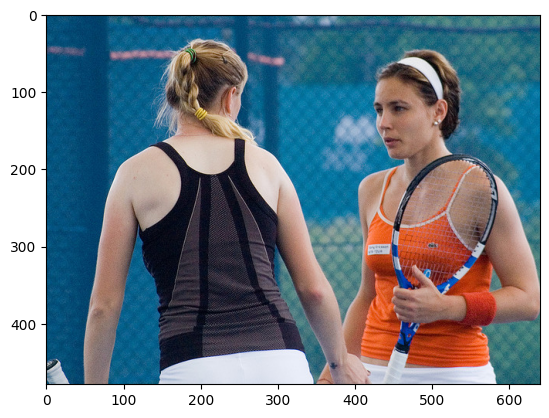

In [27]:
plt.imshow(img)

In [28]:
to_tensor = ToTensor()
resize = Resize(256)
random_crop = RandomCrop(256)

In [29]:
img = micro_vqa['train'][0]['image']
img = to_tensor(random_crop(resize(img))).unsqueeze(0)

## Converting to patches

In [30]:
patches = mg.images_to_patches(img)

In [31]:
patches.shape

torch.Size([1, 256, 768])

In [32]:
patches = patches.view(1, 256, 16, 16, 3)

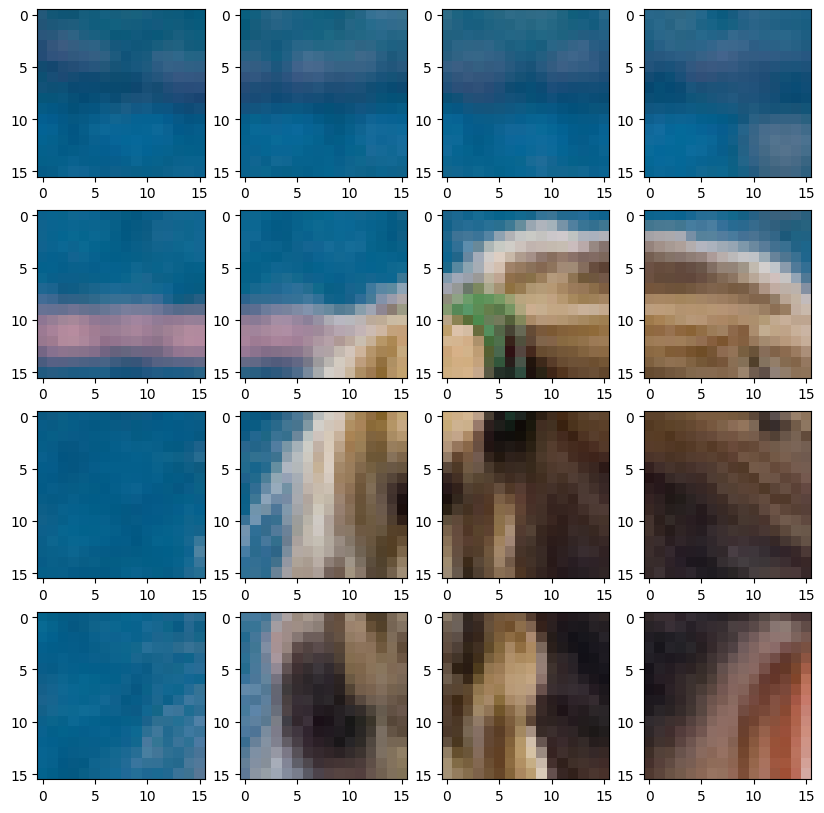

In [33]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for row in range(4):
    for col in range(4):
        axes[row][col].imshow(patches[0][row * 16 + col])

And then, to verify we can go both ways, let's convert the patches back to the original image.

In [34]:
patches.shape

torch.Size([1, 256, 16, 16, 3])

In [35]:
reconstructed = mg.patches_to_image(patches, (3, 256, 256))

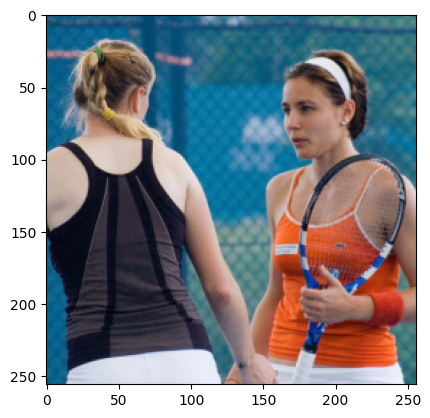

In [36]:
plt.imshow(reconstructed[0].permute(1, 2, 0))

# Example training run.

In [37]:
model = mg.init_model()
lm_head = torch.nn.Linear(model.config.hidden_size, mg.text_tokenizer.vocab_size)

In [38]:
mg.remove_embedding_layer_from_model(model)

In [39]:
params = (
    list(model.parameters())
    + list(mg._lookup_embedding.parameters())
    + list(mg._image_embedding.parameters())
)
optimizer = mg.init_optimizer(params)

In [40]:
text_dataset = (
    load_dataset(path="wikitext", name="wikitext-2-v1", streaming=True)
    .filter(mg.not_empty)
    .map(mg.tokenize, batched=True, batch_size=1000)
)
text_dataloader = DataLoader(
    text_dataset["train"], batch_size=2, collate_fn=mg.collate_fn
)
vqa_dataset = load_dataset("eihli/micro-ok-vqa", streaming=True).with_format(
    "torch"
)
vqa_dataloader = DataLoader(
    vqa_dataset["train"]
    .map(mg.vqa_img_transform)
    .map(mg.vqa_qa_transform, batched=True, batch_size=8)
    .map(mg.vqa_img_tokenize, batched=True, batch_size=8, remove_columns=["answers", "question", "answer_type", "question_type", "confidence"]),
    batch_size=2,
)

In [41]:
from accelerate import Accelerator
accelerator = Accelerator()
device = accelerator.device
model, mg._lookup_embedding, mg._image_embedding, lm_head, optimizer, text_dataloader, vqa_dataloader = accelerator.prepare(model, mg._lookup_embedding, mg._image_embedding, lm_head, optimizer, text_dataloader, vqa_dataloader)

In [52]:
text_iter, vqa_iter = iter(text_dataloader), iter(vqa_dataloader)

In [53]:
text_batch, vqa_batch = next(text_iter), next(vqa_iter)
text_sequence, text_attention_mask, text_targets = mg.embed_and_sequence_text(text_batch)
vqa_sequence, vqa_attention_mask, vqa_targets = mg.embed_and_sequence_vqa(vqa_batch)
text_sequence.shape, vqa_sequence.shape, vqa_targets.shape

(torch.Size([2, 1024, 768]), torch.Size([2, 1024, 768]), torch.Size([2, 1024]))

In [54]:
x = torch.concat([text_sequence, vqa_sequence])
y = torch.concat([text_targets, vqa_targets])
m = torch.concat([text_attention_mask, vqa_attention_mask])
optimizer.zero_grad()
o = model(inputs_embeds=x)
p = lm_head(o.last_hidden_state)

## Calculating loss

See section 2.3 of the Gato paper.

> Let b index a training batch of sequences B. We define a masking function m
  such that m(b, l) = 1 if the token at index l is either from text or from
  the logged action of an agent, and 0 otherwise. The training loss for a
  batch B can then be written as...

```python
def cross_entropy(predicted, target, mask):
    # See: https://youtu.be/kCc8FmEb1nY?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&t=1553
    B, T, C = predicted.shape
    predicted = predicted.view(B * T, C)
    target = target.view(-1)
    losses = F.cross_entropy(predicted, target, reduction="none")
    losses = losses * mask.squeeze(-1).view(-1)
    loss = losses.sum() / mask.sum()
    return loss
```

In [55]:
predicted, target, mask = p, y, m
B, T, C = predicted.shape
predicted = predicted.view(B * T, C)
target = target.view(-1)
losses = F.cross_entropy(predicted, target, reduction="none")
losses = losses * mask.squeeze(-1).view(-1)
loss = losses.sum() / mask.sum()

In [56]:
# Expected loss: -ln(1/vocab_size)
# https://youtu.be/kCc8FmEb1nY?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&t=1694
-math.log(1/text_tokenizer.vocab_size)

10.82490511970208

In [57]:
# Actual loss
loss

tensor(6.3729, device='cuda:0', grad_fn=<DivBackward0>)

Now that we feel confident that our loss calculation is correct, let's run a backward pass and see if it improves.

In [58]:
loss = mg.cross_entropy(p, y, m)

In [59]:
loss.backward()

In [60]:
optimizer.step()

In [62]:
losses = []
for _ in range(10):
    # Grab tokenized data
    text_batch, vqa_batch = next(text_iter), next(vqa_iter)
    
    # Sequence it
    text_sequence, text_attention_mask, text_targets = mg.embed_and_sequence_text(text_batch)
    vqa_sequence, vqa_attention_mask, vqa_targets = mg.embed_and_sequence_vqa(vqa_batch)
    
    x = torch.concat([text_sequence, vqa_sequence])
    y = torch.concat([text_targets, vqa_targets])
    m = torch.concat([text_attention_mask, vqa_attention_mask])
    
    # Send it through the transformer
    optimizer.zero_grad()
    o = model(inputs_embeds=x)
    p = lm_head(o.last_hidden_state)
    
    # Calculate loss and backpropagate
    loss = mg.cross_entropy(p, y, m)
    loss.backward()
    losses.append(loss.detach().item())
    optimizer.step()

In [63]:
losses

[8.02981185913086,
 7.447310447692871,
 6.955989360809326,
 7.314623832702637,
 6.5802459716796875,
 8.772049903869629,
 8.335883140563965,
 8.883854866027832,
 7.79713249206543,
 8.338171005249023]